In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import gpflow
from gpflow.monitor import ModelToTensorBoard, Monitor, MonitorTaskGroup, ScalarToTensorBoard
from gpflow.mean_functions import Constant
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
gpflow.config.set_default_summary_fmt("notebook")
from gpflow.utilities import print_summary
from tqdm import tqdm

In [2]:
data_path = '/Users/ScottJeen/OneDrive - University of Cambridge/research/Modelling/emerson_data/env'

# read in the pickled data
data = pd.read_pickle(data_path)

In [3]:
# cleaning function
def cleaning(data):
   # get cooler data
    cooler_cols = data.columns.str.contains('COOLER|DEW|OUTSIDE TEMP|OUTSIDE HUMIDITY|WIND|PRESSURE \(kPa\)', regex=True)
    cooler = data.iloc[:,cooler_cols]
    
    # get target matrix of temperatures
    y = cooler.iloc[:,[14]]
    X = cooler
    
    def normalise(df):
        from sklearn.preprocessing import StandardScaler
        # retrieve values
        # vals = df.values

        # instantiate transformer
        transformer = StandardScaler()

        # fit transformer
        transformer.fit(df)

        # normalise
        norm = transformer.transform(df)

        return norm, transformer
    
    X, x_trans = normalise(X)
    y, y_trans = normalise(y)
    
    return X, x_trans, y, y_trans

In [15]:
x_axis = data.index[1]
x_axis

Timestamp('2020-07-15 11:03:00')

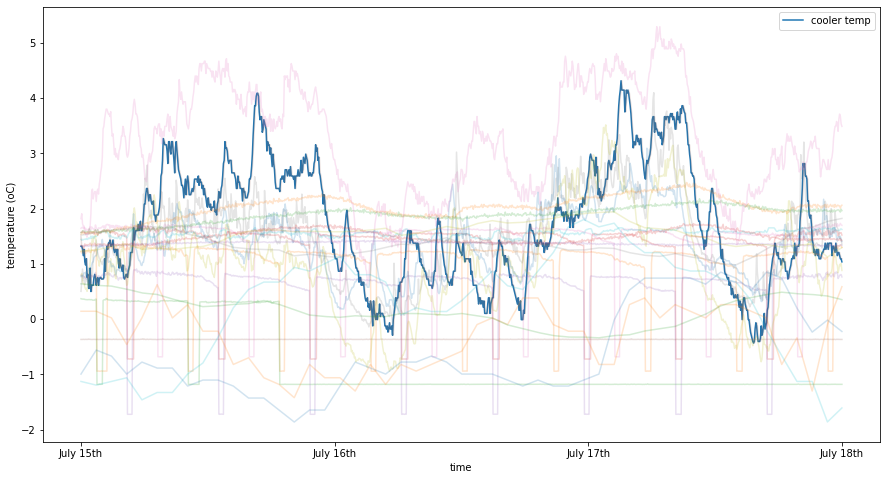

In [27]:
# clean the data
X, x_trans, y, y_trans = cleaning(data)

# take subset of data
X_s, y_s = X[:1000], y[1:1001] # target variable conditioned on X at t-1

plt.figure(figsize=(15,8))
plt.plot(np.arange(y_s.shape[0]), y_s, label='cooler temp')
plt.plot(np.arange(y_s.shape[0]), X_s, alpha=0.2)
plt.ylabel('temperature (oC)')
plt.xlabel('time')
plt.xticks(np.arange(0,1000,333),['July 15th', 'July 16th', 'July 17th', 'July 18th'] )
plt.legend(loc='upper right')
plt.savefig('temp_true.png', dpi=300)


# # split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [178]:
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor

# build the kernel
k0 = WhiteKernel(noise_level=0.05**2)
k1 = RationalQuadratic(length_scale=5, alpha=1)
kernel = k0 + k1

# define GP regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25, alpha=0)

# split the data
prop_train = 0.7
n_train = round(prop_train * X_s.shape[0])

X_train = X_s[:n_train]
y_train = y_s[:n_train]

X_test = X_s[n_train:]
y_test = y_s[n_train:]

array([[ 1.21703599,  0.36997978,  1.57067805, ..., -0.99503557,
         0.14214778,  0.63885489],
       [ 1.19706126,  0.36480351,  1.5760733 , ..., -0.97332168,
         0.14214778,  0.63747769],
       [ 1.2586499 ,  0.36307809,  1.59585628, ..., -0.95160778,
         0.14214778,  0.63610049],
       ...,
       [ 1.15378265, -1.18116487,  1.53470888, ..., -0.16447917,
        -0.82082442, -0.30383917],
       [ 1.13880163, -1.18116487,  1.53291041, ..., -0.11562292,
        -0.82082442, -0.30177337],
       [ 1.12049147, -1.18289028,  1.53291041, ..., -0.06676666,
        -0.82082442, -0.29970757]])

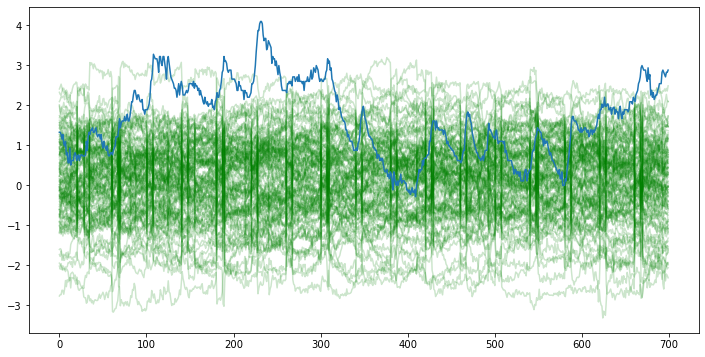

In [174]:
# sample from the prior
gp_prior = gp.sample_y(X=X_train, n_samples=100)
plt.figure(figsize=(12,6))
for i in range(100):
    plt.plot(np.arange(X_train.shape[0]), gp_prior[:,i], color='green', alpha=0.2)
plt.plot(np.arange(X_train.shape[0]), y_train)

In [175]:
gp.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0,
                         kernel=WhiteKernel(noise_level=0.0025) + RationalQuadratic(alpha=1, length_scale=5),
                         n_restarts_optimizer=25)

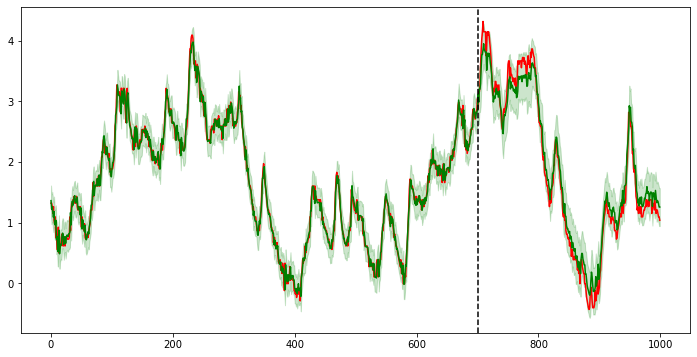


Train RMSE: 0.1155
Train MAE: 0.0874

Test RMSE: 0.2056
Test MAE: 0.1759


In [176]:
# generate predictions
y_pred, y_std = gp.predict(X_s, return_std=True)
y_lower = y_pred.flatten() - 2*y_std.flatten()
y_upper = y_pred.flatten() + 2*y_std.flatten()

# plot
plt.figure(figsize=(12,6))
plt.plot(np.arange(X_s.shape[0]), y_s, color='red')
plt.plot(np.arange(X_s.shape[0]), y_pred, color='green')
plt.fill_between(np.arange(X_s.shape[0]), y_lower, y_upper, color='green', alpha=0.2)
plt.axvline(n_train, color='black', linestyle='--')
plt.show()

# errors
train_rmse = np.sqrt(mean_squared_error(y_pred[:n_train],y_s[:n_train]))
train_mae = mean_absolute_error(y_pred[:n_train], y_s[:n_train])
test_rmse = np.sqrt(mean_squared_error(y_pred[n_train:],y_s[n_train:]))
test_mae = mean_absolute_error(y_pred[n_train:], y_s[n_train:])

print('\nTrain RMSE: {:.4f}'.format(train_rmse))
print('Train MAE: {:.4f}'.format(train_mae))
print('\nTest RMSE: {:.4f}'.format(test_rmse))
print('Test MAE: {:.4f}'.format(test_mae))


Text(0.5, 0, 'Confidence Interval')

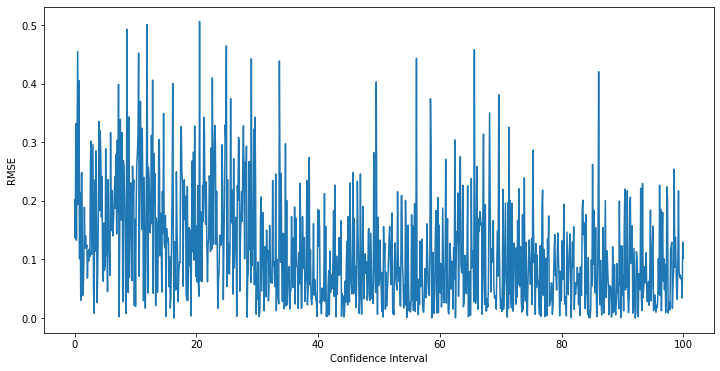

In [177]:
y_var = y_std ** 2

ranked_confidence_list = np.argsort(y_var, axis=0).flatten()
conf = np.linspace(0,100,1000)
rmse_conf = []

for k in range(len(y_pred)):
    index = ranked_confidence_list[k]
    rmse = np.sqrt(mean_squared_error(y_pred[index], y_s[index]))
    rmse_conf.append(rmse)

rmse_conf = np.asarray(rmse_conf)
rmse_conf = np.flip(rmse_conf)

plt.figure(figsize=(12,6))
plt.plot(conf, rmse_conf)
plt.ylabel('RMSE')
plt.xlabel('Confidence Interval')

## GPFlow Model

In [24]:
# build kernel
lengthscales = [0.75] * X.shape[1]
k = gpflow.kernels.Matern52(lengthscales=lengthscales)

# build model
model = gpflow.models.GPR(data=(X_train, y_train), kernel=k, mean_function=Constant(np.mean(y_train)), noise_variance=1)
model.likelihood.variance.assign(0.01)

# define optimisation objective - the log marginal likelihood
def objective_closure():
    return -model.log_marginal_likelihood()

In [25]:
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,,,True,(),float64,-0.284562075866295
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[0.75]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.01000000000000004


In [ ]:
# define optimizer
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(objective_closure,\
                        model.trainable_variables,
                        options=dict(maxiter=100)
                        )
print_summary(model)

  0%|          | 0/10 [6:11:11<?, ?it/s]


In [16]:
# mean and variance GP prediction
y_pred, y_var = model.predict_f(X_test)
# y_pred = y_trans.inverse_transform(y_pred)
y_test = y_trans.inverse_transform(y_test)

# output RMSE
y_pred_train, _ = model.predict_f(X_train)
# y_pred_train = y_trans.inverse_transform(y_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

print('\nTrain RMSE: {:.3f}'.format(train_rmse))

rmse = np.sqrt(mean_squared_error(y_pred, y_test))
mae = mean_absolute_error(y_pred, y_test)

print('\nTest RMSE: {:.3f}'.format(rmse))
print('Test MAE: {:.3f}'.format(mae))


Train RMSE: 0.000

Test RMSE: 2.900
Test MAE: 2.899


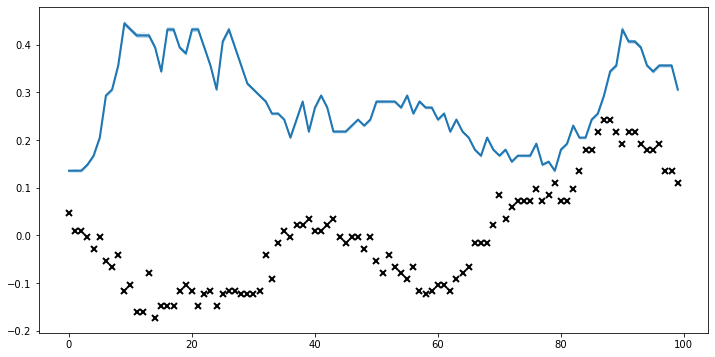

In [99]:
# # generate test points for prediction
# xx = np.asarray(X[100:200].copy())

# # predict mean and variance of latent GP at test points
# mean, var = model.predict_y(xx)

# # generate 10 samples from the posterior
# samples = model.predict_f_samples(xx, 10)

# # plot
# x = np.linspace(0, 99, 100).reshape(100,1)

# plt.figure(figsize=(12,6))
# plt.plot(x, Zy, 'kx', mew=2)
# plt.plot(x, mean, 'C0', lw=2)
# plt.fill_between(
#     x[:, 0],
#     mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
#     mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
#     color="C0",
#     alpha=0.2,
# )
# plt.plot(x, samples[:,:,0].numpy().T, 'C0', linewidth=0.1)


In [93]:
samples[:,:,0].numpy()

array([[-0.02701817, -0.05309585, -0.02955012, -0.03988562, -0.02973918,
        -0.01698373,  0.00906819,  0.02235349,  0.03510141,  0.02313748,
         0.05809728,  0.07130597,  0.07291395,  0.08441394,  0.12405043,
         0.09874941,  0.1356388 ,  0.13676718,  0.10937218,  0.11322732,
         0.08591051,  0.06096062, -0.00417019, -0.0414184 , -0.11767849,
        -0.11642434, -0.18748639, -0.26338421, -0.35011099, -0.40787519,
        -0.42116661, -0.40987107, -0.42284073, -0.42142011, -0.4347984 ,
        -0.40880066, -0.42321824, -0.394498  , -0.36435711, -0.33765378,
        -0.32549662, -0.31437162, -0.31452623, -0.27559854, -0.27554063,
        -0.23626253, -0.23983443, -0.22230753, -0.22526327, -0.22672776,
        -0.19881884, -0.14978446, -0.11779781, -0.05500479,  0.04715648,
         0.0720591 ,  0.15703736,  0.23048009,  0.19453505,  0.19173575,
         0.1796703 ,  0.15442079,  0.11061524,  0.07254723,  0.00826   ,
        -0.12202042, -0.13649426, -0.14992461, -0.1

In [95]:
model.training_loss

TypeError: 'method' object is not subscriptable

## SVGP Model

In [ ]:
# build kernel
lengthscales = [0.3] * X.shape[1]
k = gpflow.kernels.Matern52(lengthscales=lengthscales)

M = 50 # number of inducing locations
Z = X[:50, :].copy() 

# build model
m = gpflow.models.SVGP(k, gpflow.likeligoods.Gaussian(), Z, num_data=X.shape[0]) # mean = 0
model.likelihood.variance.assign(0.01)

